<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/ConvolutionClassifierClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution neural network Covid-Mask-Classifier example

* Deep learning: 1000 immagini (train,test) --> Transfer learning 100 immagini
* Machine Learing: 200 immagini
* VGGNet, AlexNet, GoogleNet,ResNet --> Funzionano per immagini di 256x256


* [Kaggle](https://www.kaggle.com/datasets?fileType=csv)
* [Google dataset](https://datasetsearch.research.google.com/)
* [Kaggle Medical Image Xray](https://www.kaggle.com/andrewmvd/medical-mnist)

## Imports

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import cv2
import torch.nn as nn
import os
from PIL import Image
import pandas as pd
import cv2
import numpy as np

## Download Dataset


## Cifar-10 Dataset

* [Pytorch Cifar 10 dataset Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
* [Paper with code Image classification Cifar dataset](https://paperswithcode.com/sota/image-classification-on-cifar-10)

In [ ]:
# Cifar-10 and Cifar-100 https://www.cs.toronto.edu/~kriz/cifar.html

# Bash download
#!wget -c https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvzf cifar-10-python.tar.gz

# Darknet cifar png dataset
#!wget http://pjreddie.com/media/files/cifar.tgz
#!tar xzf cifar.tgz

# Pytorch download
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

# Raw images download
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027
Receiving objects: 100% (60027/60027), 19.94 MiB | 64.62 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Checking out files: 100% (60001/60001), done.


tensor([0, 1, 9, 4, 3, 8, 2, 2, 5, 0])


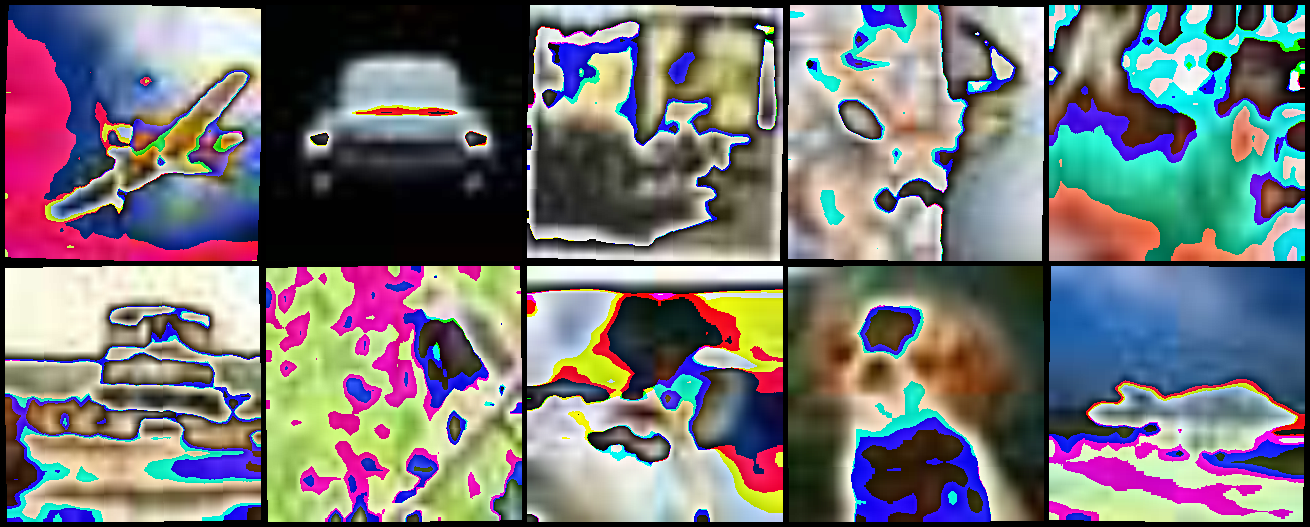

In [ ]:
folder_train_path = os.path.join("CIFAR-10-images","train")
folder_test_path = os.path.join("CIFAR-10-images","test")
classes = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,  'dog': 5,  'frog':6, 'horse':7, 'ship':8, 'truck':9}

train_transform = transforms.Compose([                                    
                                    #transforms.ToPILImage(),  # Tensor of Numpy array to Pillow
                                    transforms.Resize((256,256)),
                                    #transforms.RandomApply([
                                    #    transforms.ColorJitter(brightness=0.5,contrast=0.3),
                                    #], p=0.5),
                                    transforms.RandomApply([
                                        transforms.RandomAffine(degrees=3)
                                    ], p=0.5),
                                    transforms.RandomHorizontalFlip(p=0.5), # Pillow transformation
                                    transforms.ToTensor(),          # Pillow to tensor [0-1]
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])   
test_transform = transforms.Compose([      
                                    transforms.Resize((256,256)),                              
                                    transforms.ToTensor(),          # Pillow to tensor [0-1]
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])  
class ImageDataset(Dataset):
    def __init__(self, folder_path,classes,transform=None):
        names = os.listdir(folder_path) 
        self.filepaths = []
        self.y = []
        for c in classes.keys():
            folder_class = os.path.join(folder_path,c)
            names = os.listdir(folder_class)
            f = [os.path.join(folder_path,c,name) for name in names]
            self.filepaths.extend(f)
            self.y.extend([classes[c] for i in range(0,len(f))])
        self.transform = transform
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        y = self.y[index]
        x = Image.open(filepath)
        #m = np.array(x)
        #print(m)
        if self.transform:
            x =self.transform(x)
        return x,y
    def __len__(self):
        return len(self.filepaths)

C_train_ds = ImageDataset(folder_train_path,classes,train_transform)
C_test_ds = ImageDataset(folder_test_path,classes,test_transform)

C_train_dl = torch.utils.data.DataLoader(C_train_ds,batch_size=10,shuffle=True)
for x,y in C_train_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=5)
    im = transforms.ToPILImage()(batch_grid)
    display(im)
    break

## Covid Mask Classifier

In [2]:
!git clone https://github.com/visiont3lab/covid-mask-classifier.git

Cloning into 'covid-mask-classifier'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 1084 (delta 26), reused 15 (delta 3), pack-reused 1013
Receiving objects: 100% (1084/1084), 89.00 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [3]:
folder_path = os.path.join("covid-mask-classifier","dataset")
classes = {'mask': 0, 'no-mask': 1}
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 256

In [4]:
X = []
Y = []
for i in range(0,num_classes): #0,1
    fpath = os.path.join(folder_path, class_name[i])
    # /content/covid-mask-classifier/dataset/mask
    # /content/covid-mask-classifier/dataset/no-mask
    for name in os.listdir(fpath):
        path_read_im = os.path.join(fpath, name)
        im = np.array( Image.open(path_read_im).convert('RGB').resize((size,size)) ) # array 0-255
        #im = cv2.imread(path_read_im,1)
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        #im = cv2.resize(im,(size,size))
        X.append(im)
        Y.append(i)
X = np.array(X,dtype=np.float32).transpose(0,3,1,2)
Y = np.array(Y,dtype=np.float32)
X.shape # NxCxHxW


(999, 3, 256, 256)

* Raccolgo immagini -->250 immagini train 250 test --> 500 immagini
* Dimensione dataset --> 256
* preparazione


In [5]:
# Generate Train test folder
folder_path = os.path.join("covid-mask-classifier","dataset")
classes = {'mask': 0, 'no-mask': 1}
## -----------  Read Data
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 256
X = []
Y = []
for i in range(0,num_classes):
    fpath = os.path.join(folder_path, class_name[i])
    for name in os.listdir(fpath):
        path_read_im = os.path.join(fpath, name)
        im = np.array( Image.open(path_read_im).convert('RGB').resize((size,size)) )
        X.append(im)
        Y.append(i)
C_X = np.array(X, dtype="float32").transpose(0,3,1,2)
C_Y = np.array(Y, dtype="float32")
C_X_train, C_X_test, C_Y_train, C_Y_test = train_test_split(C_X,C_Y,test_size=0.3,shuffle=True,random_state=2)
print(f"X Train shape: {C_X_train.shape} , X Test shape: {C_X_test.shape}")

X Train shape: (699, 3, 256, 256) , X Test shape: (300, 3, 256, 256)


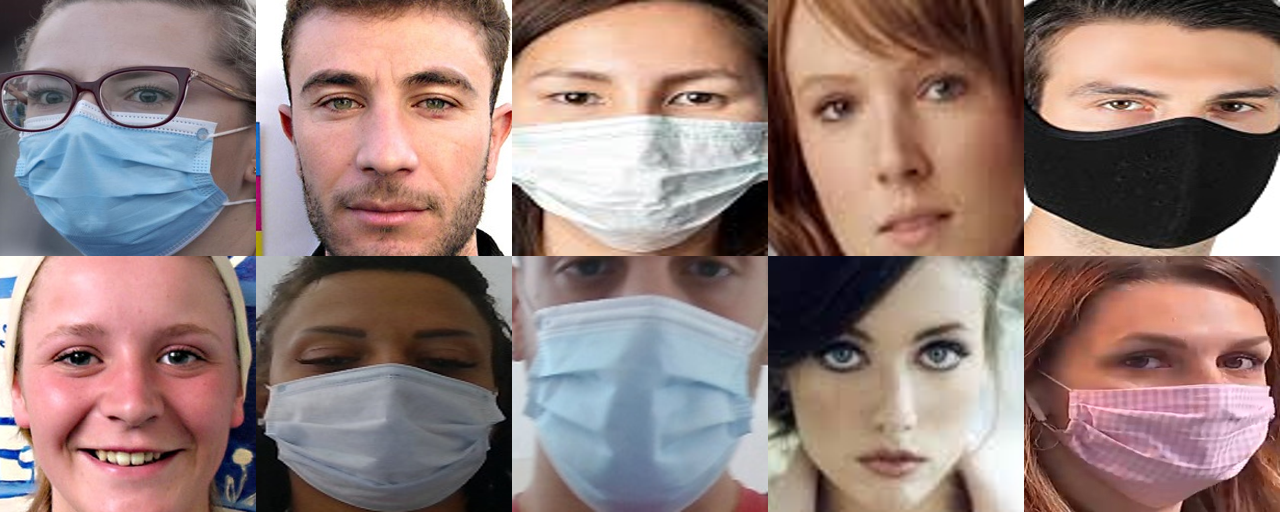

tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 0])


In [6]:
# Tensor Dataset Che converte i dati da numpy a Pytorch
class ImageDataset(Dataset):
    def __init__(self, x,y):
        self.x = torch.from_numpy(x).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.LongTensor).reshape(-1)
    def __getitem__(self, index):
        x = self.x[index]/255
        y = self.y[index]
        return x, y
    def __len__(self):
        return self.x.shape[0]

C_train_ds = ImageDataset(C_X_train,C_Y_train)
C_train_dl = torch.utils.data.DataLoader(C_train_ds,batch_size=10,shuffle=True)
C_test_ds = ImageDataset(C_X_test,C_Y_test)
C_test_dl = torch.utils.data.DataLoader(C_test_ds,batch_size=10,shuffle=True)

for x,y in C_test_dl:
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=0)
    display( transforms.ToPILImage()(batch_grid) )
    print(y)
    break


In [ ]:
data_transform = transforms.Compose([transforms.ToPILImage(),  # Tensor of Numpy array to Pillow
                                    transforms.ToTensor(),          # Pillow to tensor [0-1]
                            ])   

# Tensor Dataset Che converte i dati da numpy a Pytorch
class ImageDataset(Dataset):
    def __init__(self, x,y,transform):
        self.transform = transform
        self.x = torch.from_numpy(x).type(torch.float32)
        self.y = torch.from_numpy(y).type(torch.LongTensor).reshape(-1)
    def __getitem__(self, index):
        x = self.x[index]
        if self.transform:
          x = self.transform(x)
        y = self.y[index]
        return x, y
    def __len__(self):
        return self.x.shape[0]

C_train_ds = ImageDataset(C_X_train,C_Y_train,data_transform)
C_test_ds = ImageDataset(C_X_test,C_Y_test,data_transform)

C_train_dl = torch.utils.data.DataLoader(C_train_ds,batch_size=10,shuffle=True)
for x,y in C_train_dl: 
    print(y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=0)
    im = transforms.ToPILImage()(batch_grid*255)
    display(im)
    break

## Network

* [AdaptiveAvgPool2d](https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d)
* [AlexNet Pytorch](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)

In [52]:
!rm -rf images
!mkdir -p images

In [ ]:
!zip -r images.zip images

In [56]:
from datetime import datetime
class AlexNetSmall(nn.Module):

    def __init__(self,num_classes):
        super(AlexNetSmall, self).__init__()

        self.store = None
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        #self.drop1 = nn.Dropout(p=0.5)
        #self.drop2 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        #self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
 
    def forward(self, x):
        # Estrattore di feature
        #print("Input:",x.shape)

        x = torch.relu(self.conv1(x))
        #print("Conv1:",x.shape)
        x = self.pool1(x)
        #print("Pool1:",x.shape)

        x = torch.relu(self.conv2(x))
        #print("Conv2:",x.shape)
        x = self.pool2(x)
        #print("Pool2:",x.shape)

        x = torch.relu(self.conv3(x))
        #print("Conv3:", x.shape)
        x = torch.relu(self.conv4(x))
        #print("Conv4:", x.shape)
        x = torch.relu(self.conv5(x))
        #print("Conv5:", x.shape)
        x = self.pool3(x)
        #print("Pool3:", x.shape)
        
        x = self.avgpool(x)
        #print("AvgPool",x.shape)
        #self.plot(x.cpu())
        self.store = x

        # Classificatore
        x = x.reshape(-1,256*6*6)
        x = torch.relu( self.fc1(x) )
        x = self.fc3(x)   
        return x

    def plot(self):
        x = self.store.cpu()
        xx = x[0].unsqueeze(1)
        batch_grid =torchvision.utils.make_grid(xx, nrow=20, padding=5,keep_channels=True).permute(1, 2, 0)
        #print(batch_grid.shape)
        im = batch_grid.numpy()*255
        r = datetime.now().strftime("%H-%M-%S-%f")
        #print(r)
        im = cv2.resize(im, (1280,720))
        cv2.imwrite("images/image_"+r+".png", im)
        #fig = plt.figure(figsize=(20,10))
        #plt.imshow(batch_grid*255, interpolation="nearest") #,aspect='auto')
        #plt.axis("off")
        #plt.savefig("image.png")

x,y = next(iter(C_train_dl))
#print(x.shape)
#print(x.shape)
net = AlexNetSmall(num_classes=2)
out = net.forward(x)
#print(out)

#for p in net.parameters():
#    print(p.shape)

In [ ]:

class AlexNet(nn.Module):
    
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# Example
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.reshape(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=-1)
        return x



## Training

In [57]:
# Validation: Metric Regression
def metrics_func_regression(target, output):
  # Comptue mean squaer error (Migliora quanto piu' ci avviciniamo a zero)
  mse = torch.sum((output - target) ** 2)
  return mse

# Validation: Metric cassification
def metrics_func_classification(target, output):
  # Compute number of correct prediction
  pred = output.argmax(dim=-1,keepdim=True)
  corrects =pred.eq(target.reshape(pred.shape)).sum().item()
  return -corrects # minus for coeherence with best result is the most negative one

# Training: Loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
  # obtain loss
  loss = loss_func(yb_h, yb)
  # obtain permormance metric 
  metric_b = metric_func(yb,yb_h)
  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  return loss.item(), metric_b

# Trainig: Function 1 epoch
def loss_epoch(model, loss_func,metric_func, dataset_dl, opt, device):
  loss = 0.0
  metric = 0.0
  len_data = len(dataset_dl.dataset)
  # Get batch data
  for xb,yb in dataset_dl:    
    # Send to cuda the data (batch size)
    xb = xb.to(device)
    yb = yb.to(device)
    # obtain model output 
    yb_h = model.forward(xb)
    # Loss and Metric Calculation
    loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
    loss += loss_b
    if metric_b is not None:
      metric+=metric_b 
  loss /=len_data
  metric /=len_data

  # Plot
  model.plot()
  return loss, metric

# Training: Iterate on epochs
def train_val(epochs, model, loss_func, metric_func, opt, train_dl,test_dl,device, path2weigths="./weights.pt"):
  lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999) #  lr = lr * gamma ** last_epoch
  best_val_metric = 1000000
  for epoch in range(epochs):
    model.train()
    train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl, opt,device)
    lr_scheduler.step()
    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, metric_func, test_dl,opt=None,device=device)
      print("epoch: %d, train_loss: %.6f, val loss: %.6f,  train_metric: %.3f test_metric: %.3f lr: %.5f)" % (epoch,train_loss, val_loss,train_metric,val_metric,opt.param_groups[0]['lr']))
      if (val_metric <= best_val_metric):        
        # Save Models (It save last weights)
        torch.save(model.state_dict(),path2weigths)
        best_val_metric = val_metric


In [59]:
# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)

# Setup
C_model = AlexNetSmall(len(classes.keys())).to(device)
C_loss_func = nn.CrossEntropyLoss(reduction="sum"); # nn.NLLLoss(reduction="sum")  #nn.BCELoss  
C_opt = optim.Adam(C_model.parameters(),lr=0.001)
C_train_dl = DataLoader(C_train_ds,batch_size=64,shuffle=True,num_workers=1)
C_test_dl = DataLoader(C_test_ds,batch_size=64,shuffle=True,num_workers=1)

# Train
train_val(20,C_model,C_loss_func,metrics_func_classification,C_opt, C_train_dl,C_test_dl,device,path2weigths="./weights_classification.pt")


cuda:0
epoch: 0, train_loss: 0.952967, val loss: 0.614275,  train_metric: -0.546 test_metric: -0.750 lr: 0.00100)
epoch: 1, train_loss: 0.869247, val loss: 0.690600,  train_metric: -0.581 test_metric: -0.497 lr: 0.00100)
epoch: 2, train_loss: 0.604257, val loss: 0.658370,  train_metric: -0.518 test_metric: -0.627 lr: 0.00100)
epoch: 3, train_loss: 0.638975, val loss: 0.368059,  train_metric: -0.577 test_metric: -0.863 lr: 0.00100)
epoch: 4, train_loss: 0.467231, val loss: 0.546146,  train_metric: -0.827 test_metric: -0.657 lr: 0.00100)
epoch: 5, train_loss: 0.449113, val loss: 0.277503,  train_metric: -0.790 test_metric: -0.917 lr: 0.00099)
epoch: 6, train_loss: 0.222073, val loss: 0.239858,  train_metric: -0.940 test_metric: -0.937 lr: 0.00099)
epoch: 7, train_loss: 0.124944, val loss: 0.108074,  train_metric: -0.971 test_metric: -0.967 lr: 0.00099)
epoch: 8, train_loss: 0.140079, val loss: 0.085337,  train_metric: -0.953 test_metric: -0.970 lr: 0.00099)
epoch: 9, train_loss: 0.101735

## Test

In [49]:
# Load Classification
device = torch.device("cpu")
#classes = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,  'dog': 5,  'frog':6, 'horse':7, 'ship':8, 'truck':9}
classes = {'mask':0, 'no-mask':1}
C_model = AlexNetSmall(len(classes)).to(device)
C_weights = torch.load("weights_classification.pt")
C_model.load_state_dict(C_weights)
C_model = C_model.to(device)

# Predict Classication
for x,y in C_test_dl:
  y_hat = C_model.forward(x).argmax(dim=-1,keepdim=True).detach().numpy().reshape(-1)

  # Visualize results
  cm = confusion_matrix(y,y_hat)
  names_pred = [ "Pred: " + n for n in classes]
  df = pd.DataFrame(cm, columns=names_pred, index=classes)
  display(df)

,Pred: mask,Pred: no-mask
mask,30,3
no-mask,0,31


,Pred: mask,Pred: no-mask
mask,33,0
no-mask,0,31


,Pred: mask,Pred: no-mask
mask,30,1
no-mask,0,33


,Pred: mask,Pred: no-mask
mask,29,0
no-mask,0,35


,Pred: mask,Pred: no-mask
mask,23,0
no-mask,0,21
